In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import glob
import quadpy
from matplotlib.offsetbox import AnchoredText
import getdist
from getdist import plots, MCSamples
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid", {'axes.grid':'False','xtick.bottom': True,'ytick.left': True})

params = {"text.usetex" : True,'font.size': 20, 'font.family':'serif', 'font.serif':'Computer Modern'}
plt.rcParams.update(params)

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
pantheon_ori_fits=pd.read_csv("pantheon_original_fit.txt",sep="\s+")

## Carregando dados EXP

In [3]:
glob.glob("./lc_fit_results*.txt")

['./lc_fit_results_EXP_FA_VARIMAX_SNLS_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_LOWZ_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_PS1_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_SDSS_Pantheon.txt',
 './lc_fit_results_EXP_FA_VARIMAX_HST_Pantheon.txt']

In [4]:
SDSS_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_SNLS_Pantheon.txt",sep="\s+")
PS1_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_PS1_Pantheon.txt",sep="\s+")
HST_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_HST_Pantheon.txt",sep="\s+")
LOWZ_fits=pd.read_csv("./lc_fit_results_EXP_FA_VARIMAX_LOWZ_Pantheon.txt",sep="\s+")

In [5]:
df_exp_bf_cuts=pd.concat([PS1_fits,LOWZ_fits,SDSS_fits,SNLS_fits,HST_fits])

In [6]:
x1_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X1"])<10.]["X1"],[10,50,90])
x2_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X2/C"])<10.]["X2/C"],[10,50,90])
x1err_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X1ERR"])<10.]["X1ERR"],[1,50,99])
x2err_2sig=np.percentile(df_exp_bf_cuts[abs(df_exp_bf_cuts["X2/CERR"])<10.]["X2/CERR"],[1,50,99])

In [7]:
df_exp=df_exp_bf_cuts[(df_exp_bf_cuts["X1"]>=-0.5) & (df_exp_bf_cuts["X1"]<=0.2) &
                      (df_exp_bf_cuts["X2/C"]>=-0.2) & (df_exp_bf_cuts["X2/C"]<=0.4) &
                      (df_exp_bf_cuts["X1ERR"]>=0.) & (df_exp_bf_cuts["X1ERR"]<=1.) &
                      (df_exp_bf_cuts["X2/CERR"]>=0.) & (df_exp_bf_cuts["X2/CERR"]<=1.) &
                      (df_exp_bf_cuts["CHISQ/NDOF"]<=15.)].reset_index(drop=True)

#### Visualizando quantas SN de cada subamostra perdemos

In [8]:
SDSS_after_cuts=len(df_exp[df_exp["SURVEY"]=="SDSS"])
SNLS_after_cuts=len(df_exp[df_exp["SURVEY"]=="SNLS"])
PS1_after_cuts=len(df_exp[df_exp["SURVEY"]=="PS1MD"])
HST_after_cuts=len(df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(CANDELS)"])+len(df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(HST)"])+len(df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(SNAP)"])
LOWZ_after_cuts=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CSP)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"])+len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"])

In [9]:
hst_comb=pd.concat((df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(CANDELS)"], df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(HST)"],df_exp[df_exp["SURVEY"]=="PS1_HST_COMBINED(SNAP)"]),axis=0).reset_index(drop=True)

In [10]:
lowz_comb=pd.concat((df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"],df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"],
                     df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"],df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"],
                     df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"],df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"]),axis=0).reset_index(drop=True)

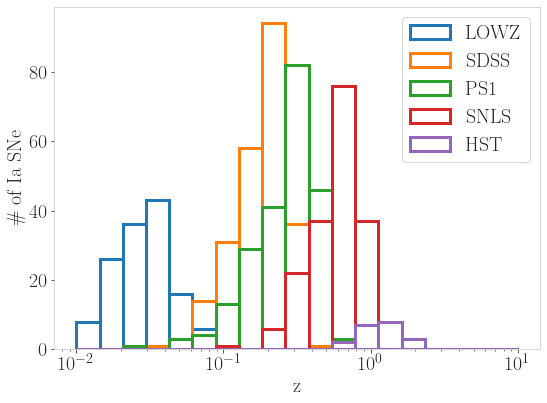

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

bins=np.logspace(-2,1,20)
ax.hist(lowz_comb["Z"],color="C0",bins=bins,label="LOWZ",edgecolor="C0",fill=False,lw=3)
ax.hist(df_exp[df_exp["SURVEY"]=="SDSS"]["Z"],color="C1",bins=bins,label="SDSS",edgecolor="C1",fill=False,lw=3)
ax.hist(df_exp[df_exp["SURVEY"]=="PS1MD"]["Z"],color="C2",bins=bins,label="PS1",edgecolor="C2",fill=False,lw=3)
ax.hist(df_exp[df_exp["SURVEY"]=="SNLS"]["Z"],color="C3",bins=bins,label="SNLS",edgecolor="C3",fill=False,lw=3)
ax.hist(hst_comb["Z"],color="C4",bins=bins,label="HST",edgecolor="C4",fill=False,lw=3)
ax.set_xlabel("z")
ax.set_ylabel("\# of Ia SNe")
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
plt.savefig('./sample_distribution_w_redshift_FA_varimax.pdf')  

In [12]:
print(f"SDSS antes dos cortes: {len(SDSS_fits)}, após os cortes: {SDSS_after_cuts}")
print(f"SNLS antes dos cortes: {len(SNLS_fits)}, após os cortes: {SNLS_after_cuts}")
print(f"PS1 antes dos cortes: {len(PS1_fits)}, após os cortes: {PS1_after_cuts}")
print(f"HST antes dos cortes: {len(HST_fits)}, após os cortes: {HST_after_cuts}")
print(f"LOWZ antes dos cortes: {len(LOWZ_fits)}, após os cortes: {LOWZ_after_cuts}")

SDSS antes dos cortes: 315, após os cortes: 238
SNLS antes dos cortes: 233, após os cortes: 179
PS1 antes dos cortes: 271, após os cortes: 222
HST antes dos cortes: 25, após os cortes: 20
LOWZ antes dos cortes: 172, após os cortes: 145


In [13]:
CFA3S_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"])
CFA3S=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3S)"])
CFA3K_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"])
CFA3K=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA3K)"])
CFA4p1_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"])
CFA4p1=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p1)"])
CFA4p2_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"])
CFA4p2=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA4p2)"])
CSP_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CSP)"])
CSP=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CSP)"])
CFA1_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"])
CFA1=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA1)"])
CFA2_bf=len(LOWZ_fits[LOWZ_fits["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"])
CFA2=len(df_exp[df_exp["SURVEY"]=="PS1_LOWZ_COMBINED(CFA2)"])

In [14]:
print(f"CFA3S antes dos cortes: {CFA3S_bf}, após os cortes: {CFA3S}")
print(f"CFA3K antes dos cortes: {CFA3K_bf}, após os cortes: {CFA3K}")
print(f"CFA4p1 antes dos cortes: {CFA4p1_bf}, após os cortes: {CFA4p1}")
print(f"CFA4p2 antes dos cortes: {CFA4p2_bf}, após os cortes: {CFA4p2}")
print(f"CSP antes dos cortes: {CSP_bf}, após os cortes: {CSP}")
print(f"CFA1 antes dos cortes: {CFA1_bf}, após os cortes: {CFA1}")
print(f"CFA2 antes dos cortes: {CFA2_bf}, após os cortes: {CFA2}")

CFA3S antes dos cortes: 31, após os cortes: 27
CFA3K antes dos cortes: 60, após os cortes: 49
CFA4p1 antes dos cortes: 33, após os cortes: 30
CFA4p2 antes dos cortes: 10, após os cortes: 6
CSP antes dos cortes: 11, após os cortes: 9
CFA1 antes dos cortes: 9, após os cortes: 9
CFA2 antes dos cortes: 18, após os cortes: 15


### Visualizando distribuições e correlações EXP

In [15]:
total_exp=len(df_exp_bf_cuts)
passcut_exp_x1=len(df_exp_bf_cuts[(df_exp_bf_cuts["X1"]>=-0.5) & (df_exp_bf_cuts["X1"]<=0.2)])
passcut_exp_x2=len(df_exp_bf_cuts[(df_exp_bf_cuts["X2/C"]>=-0.2) & (df_exp_bf_cuts["X2/C"]<=0.4)])
passcut_exp_chi2=len(df_exp_bf_cuts[df_exp_bf_cuts["CHISQ/NDOF"]<=15.])
passcut_exp_x1err=len(df_exp_bf_cuts[df_exp_bf_cuts["X1ERR"]<=1.])
passcut_exp_x2err=len(df_exp_bf_cuts[df_exp_bf_cuts["X2/CERR"]<=1.])

De um total 1048 SNe, 1016 foram bem ajustadas.
161 não passaram no corte de -0.5 < X1 < 0.2
75 não passaram no corte de -0.2 < X2 < 0.4
19 não passaram no corte de Chi2 < 15.
23 não passaram no corte de x1err < 1.
12 não passaram no corte de x2err < 1.
No final ficamos com 804 Sne.


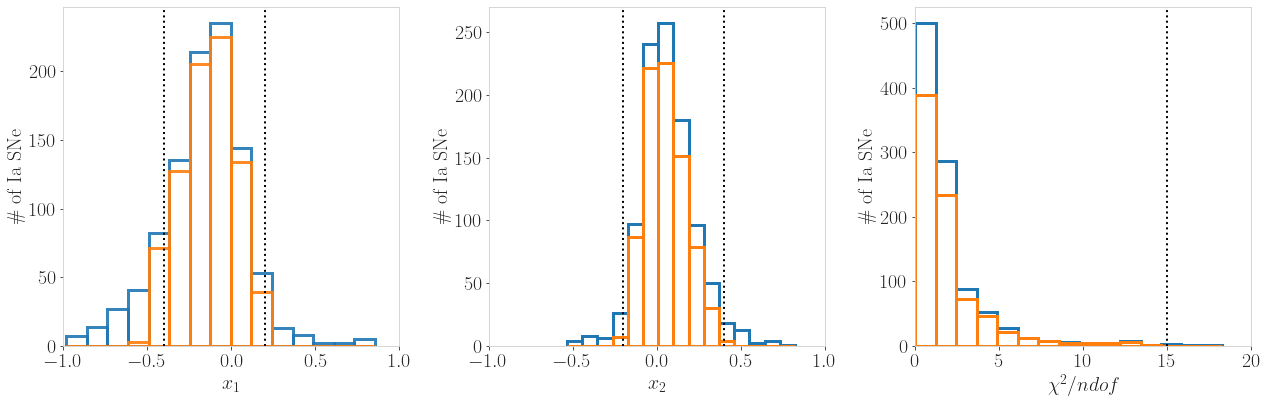

In [16]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(18,6))

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[abs(df_exp_bf_cuts["X1"])<=1.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X1"], df_exp["X1"])), bins=bins)[1]
ax1.hist(df_exp_bf_cuts["X1"],bins=bins,edgecolor="C0",alpha=0.9,fill=False,lw=3)
ax1.hist(df_exp["X1"],bins=bins,edgecolor="C1",alpha=0.9,fill=False,lw=3)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel("\# of Ia SNe")
ax1.set_xlim(-1,1)
ax1.axvline(0.2,c="k",ls=":",lw=2)
ax1.axvline(-0.4,c="k",ls=":",lw=2)

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[abs(df_exp_bf_cuts["X2/C"])<=1.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X2/C"], df_exp["X2/C"])), bins=bins)[1]
ax2.hist(df_exp_bf_cuts["X2/C"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax2.hist(df_exp["X2/C"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"$x_2$")
ax2.set_ylabel("\# of Ia SNe")
ax2.set_xlim(-1,1)
ax2.axvline(0.4,c="k",ls=":",lw=2)
ax2.axvline(-0.2,c="k",ls=":",lw=2)

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[df_exp_bf_cuts["CHISQ/NDOF"]<=20.]
bins = np.histogram(np.hstack((bf_cuts_reduced["CHISQ/NDOF"], df_exp["CHISQ/NDOF"])), bins=bins)[1]
ax3.hist(df_exp_bf_cuts["CHISQ/NDOF"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax3.hist(df_exp["CHISQ/NDOF"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel("\# of Ia SNe")
ax3.set_xlim(0,20)
ax3.axvline(15.,c="k",ls=":",lw=2)
fig.tight_layout()
plt.savefig('./distribution_FA_varimax_parameters.pdf')  

print(f"De um total 1048 SNe, {total_exp} foram bem ajustadas.")
print(f"{total_exp-passcut_exp_x1} não passaram no corte de -0.5 < X1 < 0.2")
print(f"{total_exp-passcut_exp_x2} não passaram no corte de -0.2 < X2 < 0.4")
print(f"{total_exp-passcut_exp_chi2} não passaram no corte de Chi2 < 15.")
print(f"{total_exp-passcut_exp_x1err} não passaram no corte de x1err < 1.")
print(f"{total_exp-passcut_exp_x2err} não passaram no corte de x2err < 1.")
print(f"No final ficamos com {len(df_exp)} Sne.")

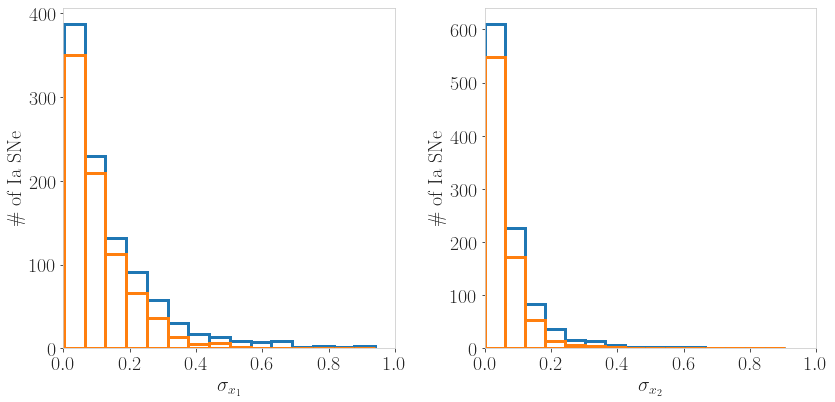

In [17]:
fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(12,6))

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[df_exp_bf_cuts["X1ERR"]<=1.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X1ERR"], df_exp["X1ERR"])), bins=bins)[1]
ax1.hist(df_exp_bf_cuts["X1ERR"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax1.hist(df_exp["X1ERR"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax1.set_xlabel(r"$\sigma_{x_1}$")
ax1.set_ylabel("\# of Ia SNe")
ax1.set_xlim(0,1)
ax1.axvline(5,c="k",ls=":",lw=2)

bins = 15
bf_cuts_reduced=df_exp_bf_cuts[df_exp_bf_cuts["X2/CERR"]<=1.]
bins = np.histogram(np.hstack((bf_cuts_reduced["X2/CERR"], df_exp["X2/CERR"])), bins=bins)[1]
ax2.hist(df_exp_bf_cuts["X2/CERR"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax2.hist(df_exp["X2/CERR"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"$\sigma_{x_2}$")
ax2.set_ylabel("\# of Ia SNe")
ax2.set_xlim(0,1)
ax2.axvline(5,c="k",ls=":",lw=2);

fig.tight_layout()
plt.savefig('./distribution_FA_varimax_parameters_errors.pdf')  

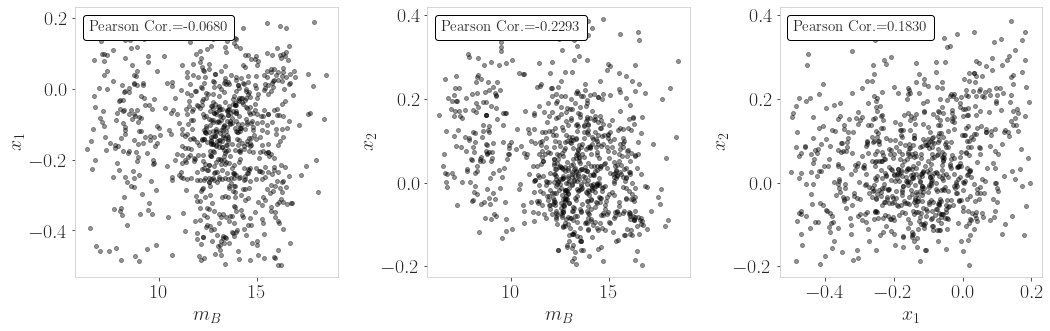

In [18]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(15,5))

ax1.plot(df_exp["mB"],df_exp["X1"],'.',c="k",markersize=8,alpha=0.4)
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_exp["mB"], df_exp["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_exp["mB"],df_exp["X2/C"],'.',c="k",markersize=8,alpha=0.4)
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"$x_2$")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_exp["mB"], df_exp["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_exp["X1"],df_exp["X2/C"],'.',c="k",markersize=8,alpha=0.4)
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"$x_2$")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_exp["X1"], df_exp["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3);
fig.tight_layout()
plt.savefig('./distribution_FA_varimax_parameters_correlations.pdf')  

In [19]:
sorted_df=df_exp.sort_values("Z").reset_index(drop=True)

In [20]:
bins_z=[]
bins_x1=[]
bins_x2=[]
i=0
while i< len(sorted_df):
    bins_z.append(np.mean(sorted_df["Z"][i:i+15]))
    bins_x1.append(np.mean(sorted_df["X1"][i:i+15]))
    bins_x2.append(np.mean(sorted_df["X2/C"][i:i+15]))
    i+=15

In [21]:
len(sorted_df)

804

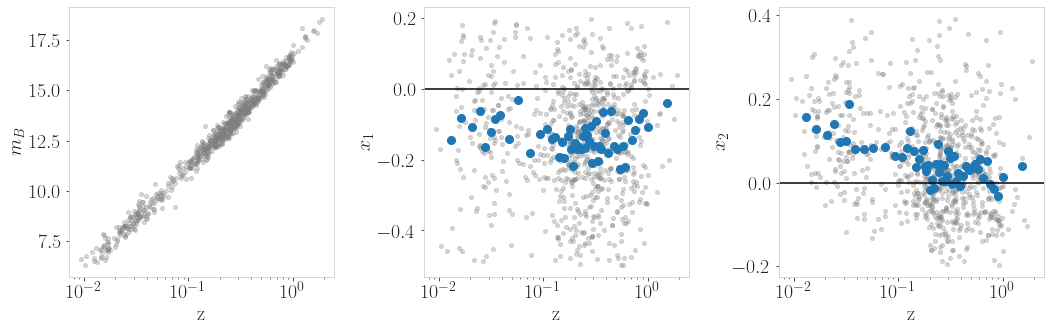

In [22]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(15,5))

ax1.plot(df_exp["Z"],df_exp["mB"],'.',c="C7",markersize=8,alpha=0.3)
ax1.set_ylabel(r"$m_B$")
ax1.set_xlabel("z")
ax1.set_xscale("log")

ax2.plot(df_exp["Z"],df_exp["X1"],".",c="C7",markersize=8,alpha=0.3)
ax2.plot(bins_z,bins_x1,marker="o", markersize=8,ls="none")
ax2.axhline(y=0.,c="k")
ax2.set_ylabel(r"$x_1$")
ax2.set_xlabel("z")
ax2.set_xscale("log")

ax3.plot(df_exp["Z"],df_exp["X2/C"],'.',c="C7",markersize=8,alpha=0.3)
ax3.plot(bins_z,bins_x2,marker="o", markersize=8,ls="none")
ax3.axhline(y=0.,c="k")
ax3.set_ylabel(r"$x_2$")
ax3.set_xlabel("z")
ax3.set_xscale("log")

fig.tight_layout()
plt.savefig('./parameters_dep_w_z_FA_varimax.pdf')  

## Carregando dados SALT2

In [23]:
glob.glob("./fits_SALT2/lc_fit_results*.txt")

['./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt',
 './fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt']

In [24]:
SDSS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SDSS_Pantheon.txt",sep="\s+")
SNLS_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_SNLS_Pantheon.txt",sep="\s+")
PS1_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_PS1_Pantheon.txt",sep="\s+")
HST_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_HST_Pantheon.txt",sep="\s+")
LOWZ_fits_SALT2=pd.read_csv("./fits_SALT2/lc_fit_results_SALT2_LOWZ_Pantheon.txt",sep="\s+")

In [25]:
df_salt2_bf_cuts=pd.concat([PS1_fits_SALT2,SNLS_fits_SALT2,SDSS_fits_SALT2,LOWZ_fits_SALT2,HST_fits_SALT2])

In [26]:
df_salt2=df_salt2_bf_cuts[(abs(df_salt2_bf_cuts["X1"])<=3.) & (abs(df_salt2_bf_cuts["X2/C"])<=0.3)].reset_index(drop=True)

### Visualizando distribuições e correlações SALT2

In [27]:
total_salt2=len(df_salt2_bf_cuts)
passcut_salt2_x1=len(df_salt2_bf_cuts[abs(df_salt2_bf_cuts["X1"])<=3])
passcut_salt2_c=len(df_salt2_bf_cuts[abs(df_salt2_bf_cuts["X2/C"])<=0.3])

De um total 1048 SNe, 1044 foram bem ajustadas.
16 não passaram no corte de |X1| < 3.
2 não passaram no corte de |C| < 0.3
No final ficamos com 1027 Sne.


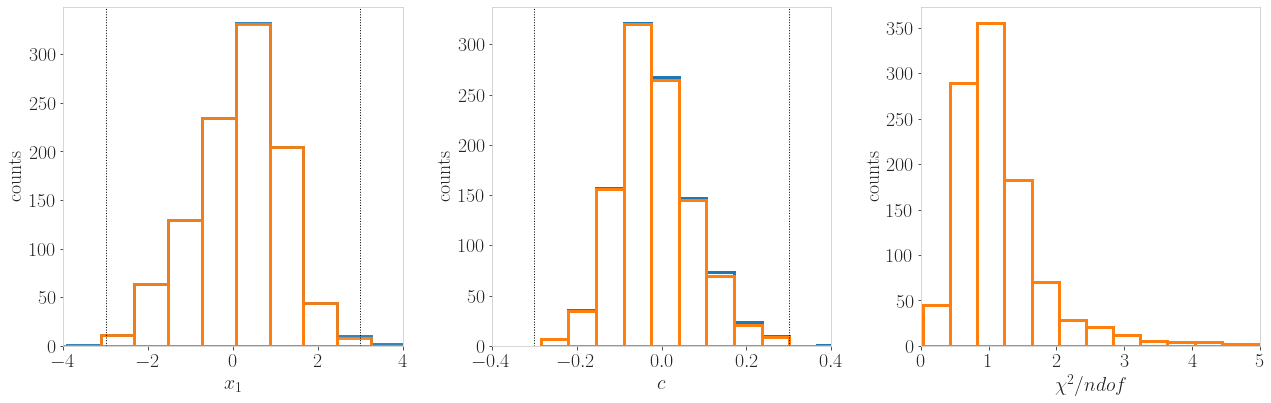

In [28]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(18,6))

bins = 20
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X1"], df_salt2["X1"])), bins=bins)[1]
ax1.hist(df_salt2_bf_cuts["X1"],bins=bins,edgecolor="C0",alpha=0.9,fill=False,lw=3)
ax1.hist(df_salt2["X1"],bins=bins,edgecolor="C1",alpha=0.9,fill=False,lw=3)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel("counts")
ax1.set_xlim(-4,4)
ax1.axvline(3.,c="k",ls=":",lw=1)
ax1.axvline(-3.,c="k",ls=":",lw=1)

bins = 15
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X2/C"], df_salt2["X2/C"])), bins=bins)[1]
ax2.hist(df_salt2_bf_cuts["X2/C"],bins=bins,edgecolor="C0",fill=False,lw=3)
ax2.hist(df_salt2["X2/C"],bins=bins,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"$c$")
ax2.set_ylabel("counts")
ax2.set_xlim(-0.4,0.4)
ax2.axvline(0.3,c="k",ls=":",lw=1)
ax2.axvline(-0.3,c="k",ls=":",lw=1)

df_salt2_reduced=df_salt2[df_salt2["CHISQ/NDOF"]<=10.]
ax3.hist(df_salt2_reduced["CHISQ/NDOF"],bins=18,edgecolor="C1",fill=False,lw=3)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel("counts")
ax3.set_xlim(0,5)
fig.tight_layout()

print(f"De um total 1048 SNe, {total_salt2} foram bem ajustadas.")
print(f"{total_salt2-passcut_salt2_x1} não passaram no corte de |X1| < 3.")
print(f"{total_salt2-passcut_salt2_c} não passaram no corte de |C| < 0.3")
print(f"No final ficamos com {len(df_salt2)} Sne.")

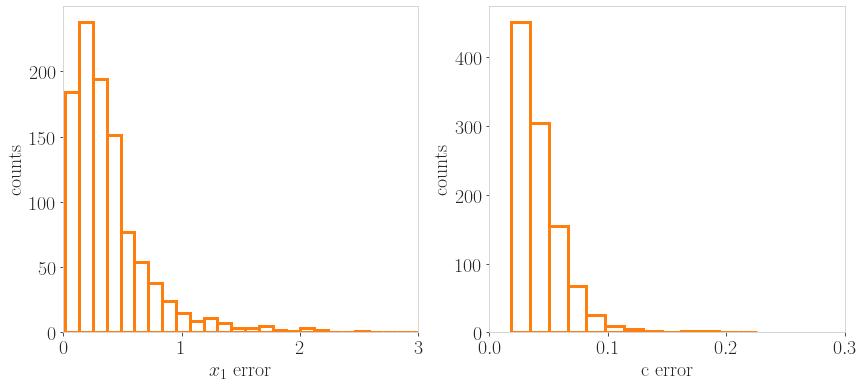

In [29]:
fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=(14,6))

ax1.hist(df_salt2["X1ERR"],bins=60,edgecolor="C1",fill=False,lw=3)
ax1.set_xlabel(r"$x_1$ error")
ax1.set_ylabel("counts")
ax1.set_xlim(0,3)

ax2.hist(df_salt2["X2/CERR"],bins=13,edgecolor="C1",fill=False,lw=3)
ax2.set_xlabel(r"c error")
ax2.set_ylabel("counts")
ax2.set_xlim(0.,0.3);

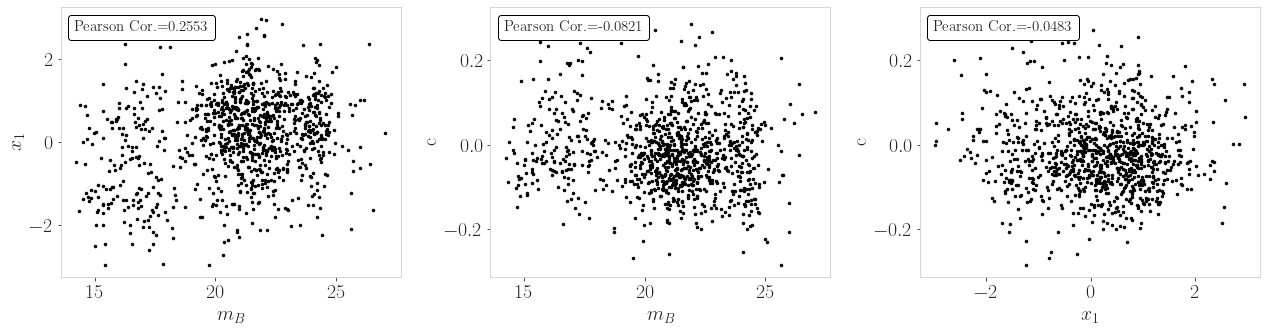

In [30]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(18,5))

ax1.plot(df_salt2["mB"],df_salt2["X1"],'.',c="k",markersize=5)
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_salt2["mB"],df_salt2["X2/C"],'.',c="k",markersize=5)
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"c")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_salt2["X1"],df_salt2["X2/C"],'.',c="k",markersize=5)
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"c")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["X1"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3); 
fig.tight_layout()

## Comparações

In [31]:
surv=[]
mb_salt2=[]
mberr_salt2=[]
mb_exp=[]
mberr_exp=[]
x1_salt2=[]
x1err_salt2=[]
x1_exp=[]
x1err_exp=[]
c_salt2=[]
cerr_salt2=[]
x2_exp=[]
x2err_exp=[]
z=[]
for sn in df_salt2["SNNAME"].values:
    if sn in df_exp["SNNAME"].values:
        surv.append(df_exp[df_exp["SNNAME"]==sn]["SURVEY"].values[0])
        mb_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["mB"].values[0])
        mberr_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["mBERR"].values[0])
        mb_exp.append(df_exp[df_exp["SNNAME"]==sn]["mB"].values[0])
        mberr_exp.append(df_exp[df_exp["SNNAME"]==sn]["mBERR"].values[0])
        x1_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X1"].values[0])
        x1err_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X1ERR"].values[0])
        x1_exp.append(df_exp[df_exp["SNNAME"]==sn]["X1"].values[0])
        x1err_exp.append(df_exp[df_exp["SNNAME"]==sn]["X1ERR"].values[0])
        c_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X2/C"].values[0])
        cerr_salt2.append(df_salt2[df_salt2["SNNAME"]==sn]["X2/CERR"].values[0])
        x2_exp.append(df_exp[df_exp["SNNAME"]==sn]["X2/C"].values[0])
        x2err_exp.append(df_exp[df_exp["SNNAME"]==sn]["X2/CERR"].values[0])
        z.append(df_exp[df_exp["SNNAME"]==sn]["Z"].values[0])

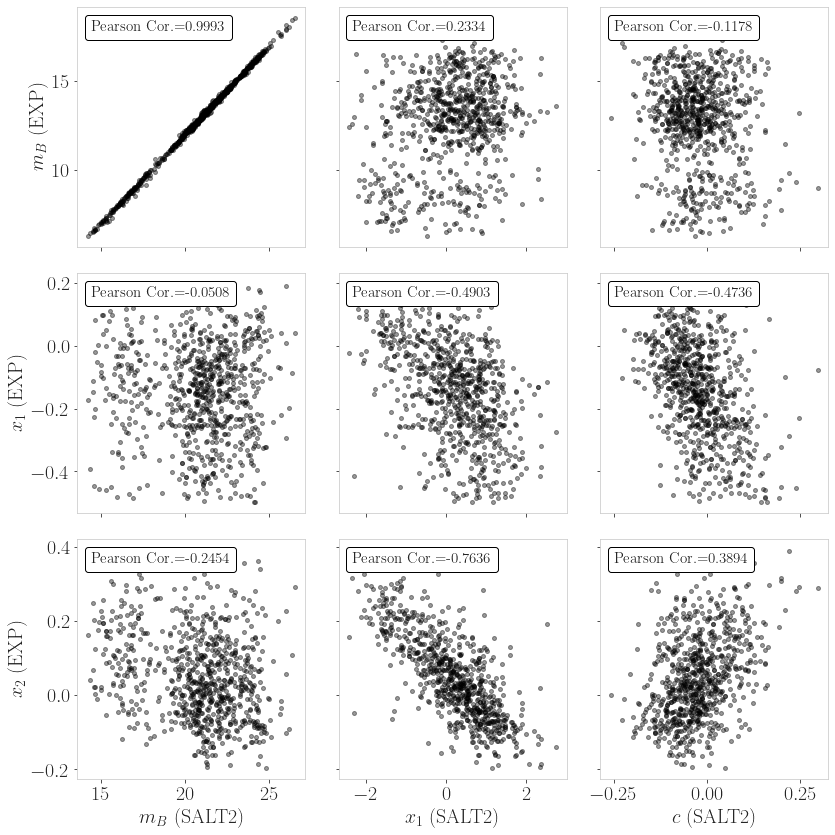

In [32]:
fig, axs=plt.subplots(3,3,figsize=(12,12),sharex='col',sharey='row')

axs[0,0].plot(mb_salt2,mb_exp,'.',c="black",markersize=8,alpha=0.4)
axs[0,0].set_ylabel(r"$m_B$ (EXP)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(mb_salt2, mb_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,0].add_artist(at1)

axs[0,1].plot(x1_salt2,mb_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, mb_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,1].add_artist(at1)

axs[0,2].plot(c_salt2,mb_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, mb_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,2].add_artist(at1)

axs[1,0].plot(mb_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
axs[1,0].set_ylabel(r"$x_1$ (EXP)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(mb_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,0].add_artist(at1)

axs[1,1].plot(x1_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,1].add_artist(at1)

axs[1,2].plot(c_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,2].add_artist(at1)

axs[2,0].plot(mb_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[2,0].set_ylabel(r"$x_2$ (EXP)")
axs[2,0].set_xlabel(r"$m_B$ (SALT2)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(mb_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[2,0].add_artist(at1)

axs[2,1].plot(x1_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[2,1].set_xlabel(r"$x_1$ (SALT2)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[2,1].add_artist(at1)

axs[2,2].plot(c_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[2,2].set_xlabel(r"$c$ (SALT2)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[2,2].add_artist(at1);
fig.tight_layout()
plt.savefig('./correlation_SALT2_EXP_FA_varimax_parameters.pdf')  

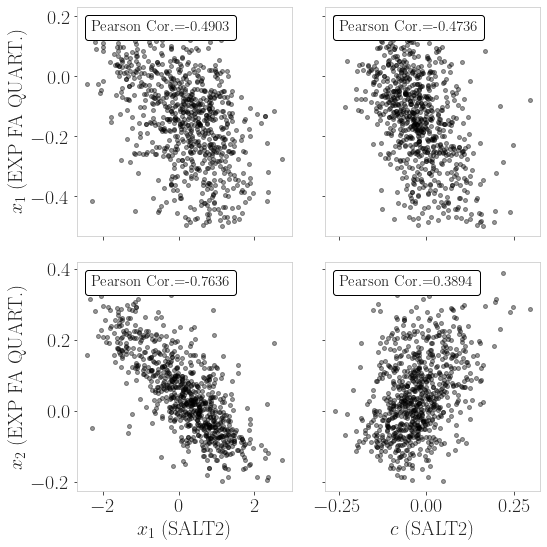

In [33]:
fig, axs=plt.subplots(2,2,figsize=(8,8),sharex='col',sharey='row')

axs[0,0].plot(x1_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
axs[0,0].set_ylabel(r"$x_1$ (EXP FA QUART.)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,0].add_artist(at1)

axs[0,1].plot(c_salt2,x1_exp,'.',c="black",markersize=8,alpha=0.4)
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, x1_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[0,1].add_artist(at1)

axs[1,0].plot(x1_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[1,0].set_xlabel(r"$x_1$ (SALT2)")
axs[1,0].set_ylabel(r"$x_2$ (EXP FA QUART.)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(x1_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,0].add_artist(at1)

axs[1,1].plot(c_salt2,x2_exp,'.',c="black",markersize=8,alpha=0.4)
axs[1,1].set_xlabel(r"$c$ (SALT2)")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(c_salt2, x2_exp)[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
axs[1,1].add_artist(at1);
fig.tight_layout()
plt.savefig('./correlation_SALT2_EXP_FA_varimax_parameters_reduced.pdf')  

## MCMC

#### MCMC EXP

In [34]:
class cosmo:
    def __init__(self, data):
        self.data = data
        
    def dL(self,Ok, integral):
        if(Ok[0]>0.):
            return 1./np.sqrt(Ok[0])*np.sinh(np.sqrt(Ok[0])*np.array(integral))
        elif(Ok[0]==0.):
            return integral
        elif(Ok[0]<0.):
            return 1./np.sqrt(-Ok[0])*np.sin(np.sqrt(-Ok[0])*np.array(integral))
    
    def log_likelihood_exp(self,theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]-2.5*np.log10(1-self.data["x1"]*alpha+self.data["x2"]*beta)-deltaM*self.data["is_log_mass_g_10"]
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        fator=-2.5/(np.log(10.)*(1-self.data["x1"]*alpha+self.data["x2"]*beta))
        
        cov=-2.*fator*alpha*self.data["cov_mB_x1"]+2.*fator*beta*self.data["cov_mB_x2"]-2.*fator**2*alpha*beta*self.data["cov_x1_x2"]
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+fator**2*alpha**2.*self.data["x1err"]**2+fator**2*beta**2.*self.data["x2err"]**2.+cov
        
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_likelihood_salt2(self,theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta

        Ok=1.-Om-Ol
        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+Ol+(1.-Om-Ol)*(1+x)**2.)
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*self.dL(np.array([Ok]*len(integral)),integral))+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["x2"]*beta-deltaM*self.data["is_log_mass_g_10"]
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_x2"]-2.*alpha*beta*self.data["cov_x1_x2"]
        sigma2=sigma**2+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["x2err"]**2.+cov
               
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior_exp(self, theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta     
        if not (0.05 < Om < 1. and -0.5 < Ol < 1.5 and 15. < M < 17. and -0.5 < deltaM < 0.5 and -5. < alpha <5. and -5.< beta < 5. and 0.<sigma <0.3):
            return -np.inf
        return 0. 
    
    def log_prior_salt2(self, theta):
        Om, Ol, M, deltaM, alpha, beta, sigma=theta     
        if not (0.05 < Om < 1. and -0.5 < Ol < 1.5 and 22. < M < 27. and -0.5 < deltaM < 0.5 and 0. < alpha < 0.5 and 0.< beta < 5. and 0.<sigma <0.3):
            return -np.inf
        return 0.   
    
    def log_probability_exp(self,theta):
        lp = self.log_prior_exp(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_exp(theta)
    
    def log_probability_salt2(self,theta):
        lp = self.log_prior_salt2(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_salt2(theta)

In [35]:
exp_data=df_exp[df_exp["SNNAME"].isin(df_salt2["SNNAME"])].reset_index(drop=True)

In [36]:
exp_data["SNNAME"]=exp_data["SNNAME"].astype("str")

In [37]:
hostmass={}

In [38]:
i=0
j=0
for sn in pantheon_ori_fits["CID"]:
    if sn in exp_data["SNNAME"].values:
        i+=1
        hostmass[sn]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
        continue
    else:
        try:
            sn_int=int(sn)
            if str(sn_int) in exp_data["SNNAME"].values:
                i+=1
                hostmass[str(sn_int)]=pantheon_ori_fits[pantheon_ori_fits["CID"]==sn]["HOST_LOGMASS"].values[0]
                continue
            else:
                j+=1
                continue
        except:
            j+=1
            continue

print(f"{j} não estão na lista")
print(f"{i} estão na lista")

254 não estão na lista
794 estão na lista


In [39]:
reduced_exp_data=exp_data[exp_data["SNNAME"].isin(hostmass.keys())].reset_index(drop=True)

In [40]:
col_hostmass=[]
is_log_mass_g_10=[]
for sn in reduced_exp_data["SNNAME"]:
    col_hostmass.append(hostmass[sn])
    if hostmass[sn]<10.:
        is_log_mass_g_10.append(0.)
    else:
        is_log_mass_g_10.append(1.)

In [41]:
col_hostmass=pd.DataFrame(col_hostmass)
col_hostmass.columns=["LOG_HOST_GAL_MASS"]
is_log_mass_g_10=pd.DataFrame(is_log_mass_g_10)
is_log_mass_g_10.columns=["is_log_mass_g_10"]

In [42]:
final_exp_data=pd.concat((reduced_exp_data,col_hostmass,is_log_mass_g_10),axis=1)

In [43]:
data_exp=final_exp_data[["SNNAME","LOG_HOST_GAL_MASS","Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C","is_log_mass_g_10"]]

In [44]:
data_exp.columns=["sn","log_hm","z","zerr","mB","mBerr","x1","x1err","x2","x2err","cov_mB_x1","cov_mB_x2","cov_x1_x2","is_log_mass_g_10"]

In [45]:
data_exp.to_csv("exp_FA_varimax_fits_table.txt",index=False)

In [46]:
len(data_exp)

794

In [47]:
cosmo_exp=cosmo(data_exp)

In [48]:
cosmo_exp.log_probability_exp([0.3,0.5,16.,0.,1.,1.,0.13])

-671.4369965036292

In [49]:
pos = np.array([0.3,0.7,16.,0.,1.,1.,0.13])+0.01 *np.random.randn(500, 7)
nwalkers, ndim = pos.shape

In [50]:
with Pool() as pool:
    sampler_exp = emcee.EnsembleSampler(nwalkers, ndim, cosmo_exp.log_probability_exp, pool=pool)
    sampler_exp.run_mcmc(pos, 10000, progress=True)

100%|█████████████████████████████████████| 10000/10000 [30:23<00:00,  5.48it/s]


In [51]:
np.mean(sampler_exp.get_autocorr_time())

76.54452110820716

In [52]:
np.mean(sampler_exp.acceptance_fraction)

0.48507000000000006

In [53]:
#plt.plot(emcee.autocorr.function_1d(samples_exp[:, 0, 0]))
#plt.axhline(y = 0., color = 'r', linestyle = '-'); 

#### MCMC SALT2

In [54]:
salt2_data=df_salt2[df_salt2["SNNAME"].isin(df_exp["SNNAME"])].reset_index(drop=True)

In [55]:
salt2_data["SNNAME"]=salt2_data["SNNAME"].astype("str")

In [56]:
reduced_salt2_data=salt2_data[salt2_data["SNNAME"].isin(hostmass.keys())].reset_index(drop=True)

In [57]:
col_hostmass=[]
is_log_mass_g_10=[]
for sn in reduced_salt2_data["SNNAME"]:
    col_hostmass.append(hostmass[sn])
    if hostmass[sn]<10.:
        is_log_mass_g_10.append(0.)
    else:
        is_log_mass_g_10.append(1.)

In [58]:
col_hostmass=pd.DataFrame(col_hostmass)
col_hostmass.columns=["LOG_HOST_GAL_MASS"]
is_log_mass_g_10=pd.DataFrame(is_log_mass_g_10)
is_log_mass_g_10.columns=["is_log_mass_g_10"]

In [59]:
final_salt2_data=pd.concat((reduced_salt2_data,col_hostmass,is_log_mass_g_10),axis=1)

In [60]:
data_salt2=final_salt2_data[["SNNAME","LOG_HOST_GAL_MASS","Z","ZERR","mB","mBERR","X1","X1ERR","X2/C","X2/CERR","COV_mB_X1","COV_mB_X2/C","COV_X1_X2/C","is_log_mass_g_10"]]

In [61]:
data_salt2.columns=["sn","log_hm","z","zerr","mB","mBerr","x1","x1err","x2","x2err","cov_mB_x1","cov_mB_x2","cov_x1_x2","is_log_mass_g_10"]

In [62]:
data_salt2.to_csv("SALT2_FA_varimax_subsample_fits_table.txt",index=False)

In [63]:
cosmo_salt2=cosmo(data_salt2)

In [64]:
cosmo_salt2.log_probability_salt2([0.3,0.5,24.,0.,0.1,3.,0.1])

104.82646258150905

In [65]:
pos = np.array([0.3,0.7,24.,0.,0.1,3.,0.1])+0.01 *np.random.randn(500, 7)
nwalkers, ndim = pos.shape

In [66]:
with Pool() as pool:
    sampler_salt2 = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2, pool=pool)
    sampler_salt2.run_mcmc(pos, 10000, progress=True)

100%|█████████████████████████████████████| 10000/10000 [25:23<00:00,  6.56it/s]


In [67]:
np.mean(sampler_salt2.get_autocorr_time())

71.70150251626353

In [68]:
np.mean(sampler_salt2.acceptance_fraction)

0.485788

#### Chains EXP

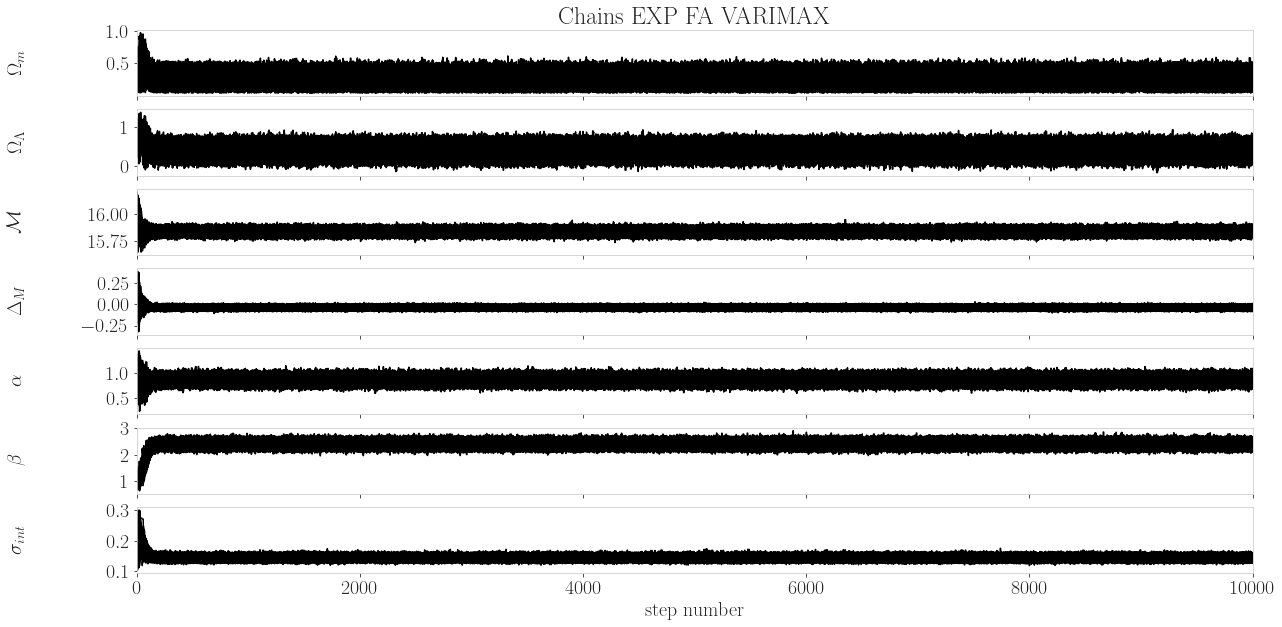

In [69]:
fig, axes = plt.subplots(ndim, figsize=(20, 10), sharex=True)
samples_exp = sampler_exp.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$", r"$\Delta_M$",r"$\alpha$",r"$\beta$",r"$\sigma_{int}$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_exp[:, :, i], "k")
    ax.set_xlim(0, len(samples_exp))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)
    if i==0:
        ax.set_title("Chains EXP FA VARIMAX")

    
axes[-1].set_xlabel("step number");

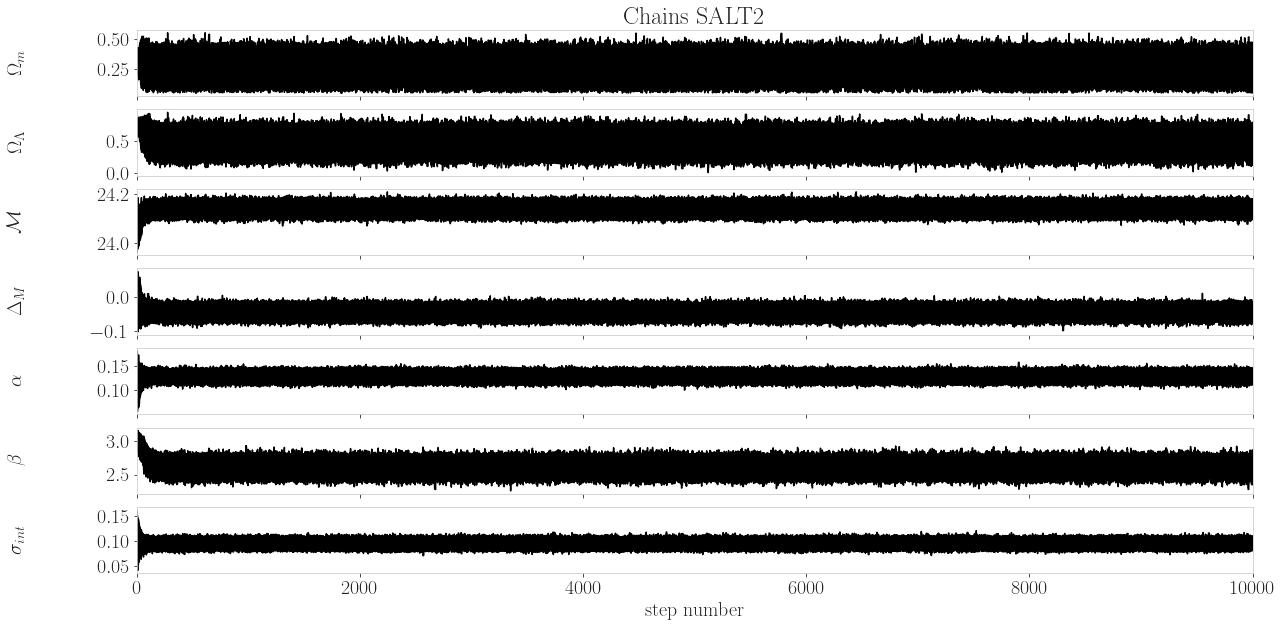

In [70]:
fig, axes = plt.subplots(ndim, figsize=(20, 10), sharex=True)
samples_salt2 = sampler_salt2.get_chain()
labels = [r"$\Omega_m$",r"$\Omega_\Lambda$",r"$\mathcal{M}$", r"$\Delta_M$",r"$\alpha$",r"$\beta$",r"$\sigma_{int}$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2[:, :, i], "k")
    ax.set_xlim(0, len(samples_salt2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(False)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [71]:
flat_samples_exp = sampler_exp.get_chain(discard=1000, thin=10, flat=True)

In [72]:
flat_samples_salt2 = sampler_salt2.get_chain(discard=1000, thin=10, flat=True)

In [73]:
np.savetxt("chain_EXP_FA_varimax.txt",flat_samples_exp)

In [74]:
np.savetxt("chain_SALT2_FA_varimax_subsample.txt",flat_samples_salt2)

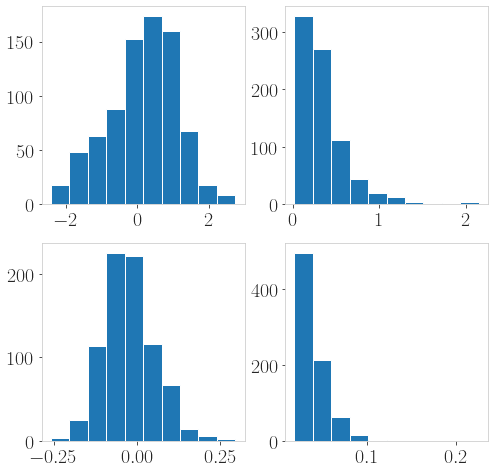

In [75]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

axs[0,0].hist(data_salt2["x1"])
axs[0,1].hist(data_salt2["x1err"])
axs[1,0].hist(data_salt2["x2"])
axs[1,1].hist(data_salt2["x2err"]);